In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
import pandas as pd

from molecular_simulations.lj_md_nve import lj_md_study

In [2]:
%%time
N = 108
rho = 0.8442
T = 0.728
delta = 0.001
pos, vel, forc, acc_u, acc_k, acc_p, rdf, corr_v = lj_md_study(
    N, rho, T, delta, eqnum=2500, snum=600000
)

CPU times: total: 3min 38s: -2.163337 U: -4.401030 K: 2.237693
Wall time: 6min 8s


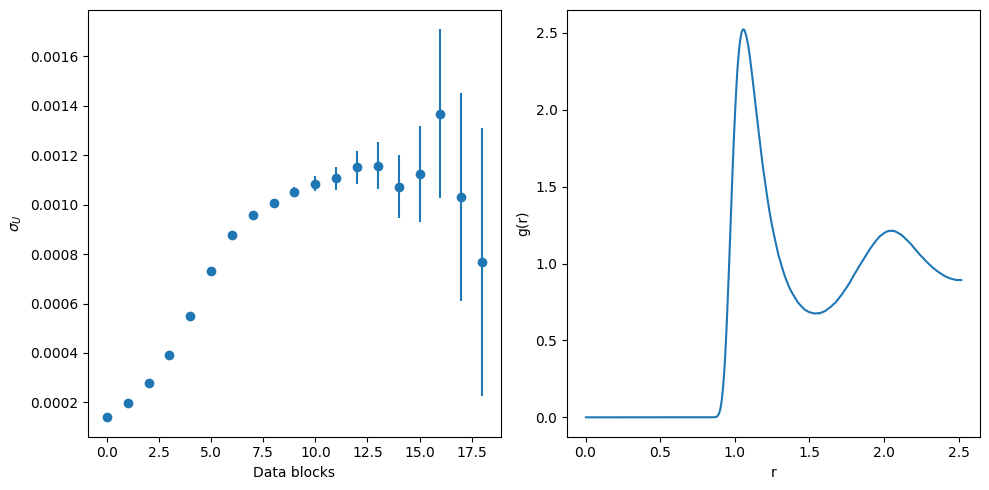

In [3]:
_, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

var_est, var_err = acc_u.block_vars_est()
axs[0].errorbar(
    np.arange(len(var_est)),
    np.sqrt(var_est),
    yerr=var_err / (2 * var_est) * np.sqrt(var_est),
    fmt="o",
)
axs[0].set_xlabel("Data blocks")
axs[0].set_ylabel("$\sigma_U$")

gr_raw = rdf.rdf()
axs[1].plot(gr_raw[:, 0], gr_raw[:, 1] / (rho * N))
axs[1].set_xlabel("r")
axs[1].set_ylabel("g(r)");

In [4]:
# Estimate U/N and P using g(r)
def u_lj(r, r_c):
    return 4 * ((1 / r) ** 12 - (1 / r) ** 6 - (1 / r_c) ** 12 + (1 / r_c) ** 6)


def du_lj(r):
    return -(48 / r) * ((1 / r) ** 12 - 0.5 * (1 / r) ** 6)


r = gr_raw[:, 0]
gr = gr_raw[:, 1] / (rho * N)

i_u = u_lj(r, 2.5) * gr * (r**2)
i_p = du_lj(r) * gr * (r**3)
u_gr = 2 * np.pi * rho * np.trapz(i_u, r)
p_gr = rho * (2 / 3) * acc_k.mean() - (2 / 3) * np.pi * (rho**2) * np.trapz(i_p, r)


# Report estimates
u_st, _ = acc_u.uncorr_stdev()
k_st, _ = acc_k.uncorr_stdev()
p_st, _ = acc_p.uncorr_stdev()


print(
    pd.DataFrame(
        [
            [acc_u.mean(), np.sqrt(u_st), u_gr],
            [acc_k.mean(), np.sqrt(k_st), np.nan],
            [acc_p.mean(), np.sqrt(p_st), p_gr],
        ],
        index=["U/N", "K", "P"],
        columns=['Average', 'Std', 'g_r est']
    )
)

      Average       Std   g_r est
U/N -4.420307  0.001107 -4.419453
K    2.256938  0.001106       NaN
P    5.177455  0.005007  5.166954


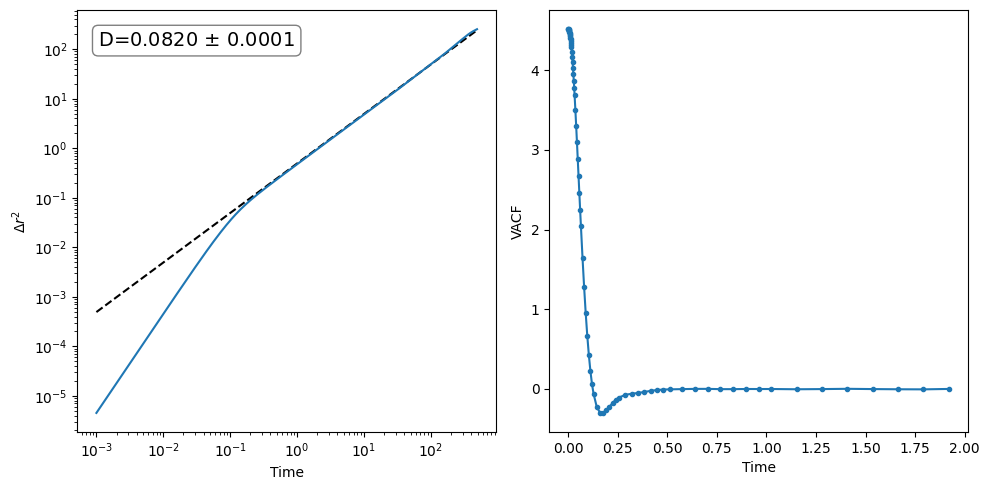

In [5]:
_, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Fit MSD with linear
msd = corr_v.msd()
time_window = (msd[:, 0] > 1 / delta) & (msd[:, 0] < 100 / delta)
c, V = np.polyfit(msd[time_window, 0] * delta, msd[time_window, 1] * delta**2, 1, cov=True)
textstr = r"D=%.4f $\pm$ %.4f" % (c[0]/6, np.sqrt(V[0][0])/6)
props = dict(boxstyle="round", facecolor="w", alpha=0.5)

msd = corr_v.msd()
axs[0].plot(msd[1:, 0] * delta, c[0] * msd[1:, 0] * delta, 'k--')
axs[0].plot(msd[1:, 0] * delta, msd[1:, 1] * delta**2, "-")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel('Time')
axs[0].set_ylabel('$\Delta r^2$')
axs[0].text(
    0.05,
    0.95,
    textstr,
    transform=axs[0].transAxes,
    fontsize=14,
    verticalalignment="top",
    bbox=props,
)

vacf = corr_v.acf()
t_delta = vacf[:, 0] < 2000
axs[1].plot(vacf[t_delta, 0] * delta, vacf[t_delta, 1], "-o", markersize=3)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('VACF');